<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdevnotebooks.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Try out the NVIDIA Multimodal PDF Data Extraction Blueprint! 🤙

Welcome!

In this notebook, we will run inference on the new NVIDIA Multimodal PDF Data Extraction Blueprint. This blueprint uses a state-of-the-art multimodal model to extract data from PDFs, PowerPoints, and images. 


**Important Notes**: 
1. In order to run this notebook, you need to visit NGC and get a key for the Multimodal PDF Data Extraction Blueprint.
3. **Because this model uses a 2xA100 cluster, it can get expensive to leave on for a long time. If you're looking to host this workflow permanently, please reach out to the Brev team and we can chat!**

**Need to contact us**! Email us at brev-support@nvidia.com

# Introduction

NVIDIA-Ingest is a scalable, performance-oriented document content and metadata extraction microservice. Including support for parsing PDFs, Word and PowerPoint documents, it uses specialized NVIDIA NIMs to find, contextualize, and extract text, tables, charts and images for use in downstream generative applications. NVIDIA Ingest enables parallelization of the process of splitting documents into pages where contents are classified (as tables, charts, images, text), extracted into discrete content, and further contextualized via optical character recognition (OCR) into a well defined JSON schema. From there, NVIDIA Ingest can optionally manage computation of embeddings for the extracted content, and also optionally manage storing into a vector database Milvus.

# Architecture

This blueprint is comprised of multiple pieces that come together to form a powerful multi-modal RAG solution

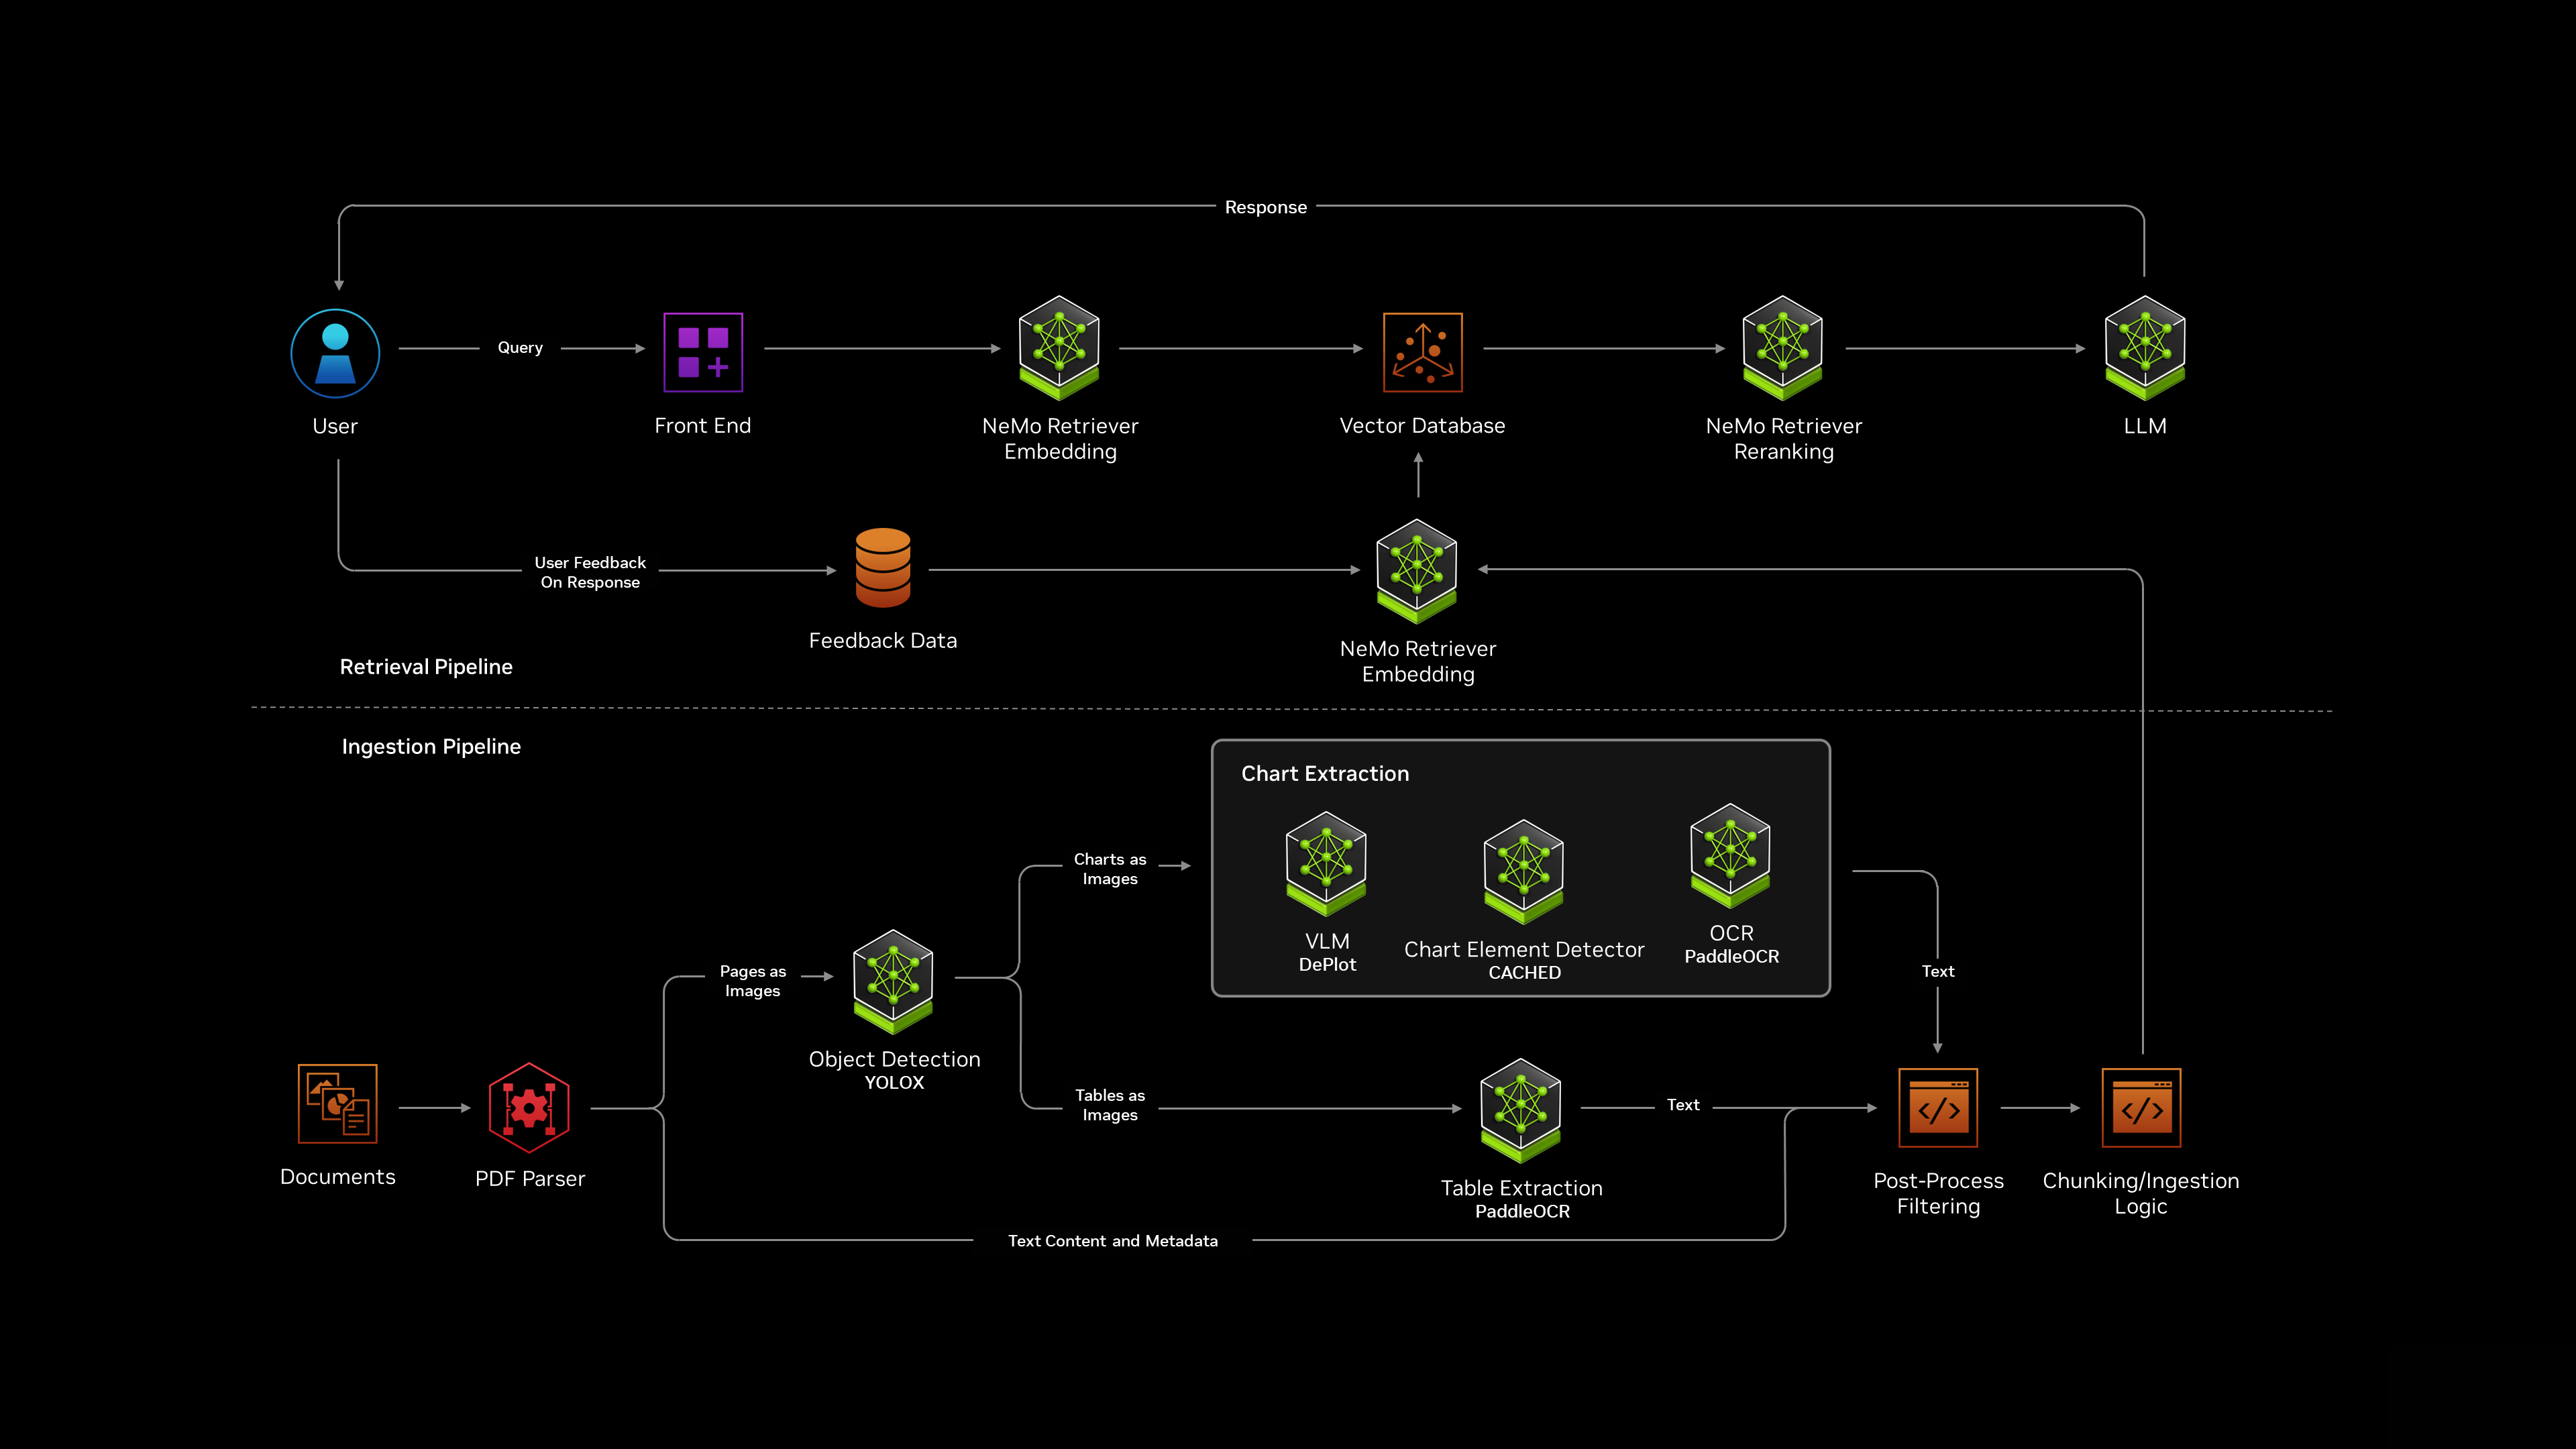

# Getting started

## Clone the repository and log into Docker

In order to spin up this blueprint, you will need an NGC api key. Talk to your NVIDIA rep or apply for access [here](https://developer.nvidia.com/nemo-microservices). After you get your API key, paste it below where we run `export NGC_API_KEY=`.

In [ ]:
%%bash

[ -d "nv-ingest" ] || git clone https://github.com/ishandhanani/nv-ingest

cd nv-ingest

export NGC_API_KEY=<enter-key-here>

echo "${NGC_API_KEY}" | docker login nvcr.io -u '$oauthtoken' --password-stdin

cat << EOF > .env
NGC_API_KEY=$NGC_API_KEY
DATASET_ROOT=/home/ubuntu/verb-workspace/data
NV_INGEST_ROOT=/home/ubuntu/verb-workspace/nv-ingest
EOF

echo ".env file has been created successfully."

## Spin up the blueprint

NOTE: This step can take about 10 minutes. The following steps are how we suggest running and monitoring your the progress. If you do not want to monitor - you can simply run `docker compose up -d` in a new terminal window

1. Open up a new terminal window and run the following

```bash
cd nv-ingest
docker compose up
```

This will run each service and output persistant logs. 

2. In a second terminal window, run

```bash
cd nv-ingest
docker compose logs -f nv-ingest-ms-runtime
```

This will show you persistant logs for the main `nv-ingest` service

### Checking for completion
Things should be spun up properly if the first part of your `nv-ingest-ms-runtime` logs show something similar to 

```bash
nv-ingest-ms-runtime-1  | INFO:     Uvicorn running on http://0.0.0.0:7670 (Press CTRL+C to quit)
nv-ingest-ms-runtime-1  | INFO:     Started parent process [20]
nv-ingest-ms-runtime-1  | INFO:     Started server process [40]
```

and the final lines look similar to 

```bash
nv-ingest-ms-runtime-1  | 2024-10-16 02:36:11,162 - DEBUG - parent_receive started child_thread
nv-ingest-ms-runtime-1  | 2024-10-16 02:36:11,162 - DEBUG - parent_receive started child_thread
nv-ingest-ms-runtime-1  | 2024-10-16 02:36:11,163 - DEBUG - parent_receive started child_thread
```

After everything is up and running, we can run `docker ps` and `nvidia-smi` 

In [44]:
!docker ps

CONTAINER ID   IMAGE                                                                      COMMAND                  CREATED         STATUS                   PORTS                                                                                                                                   NAMES
37a23bf237b7   zilliz/attu:v2.3.5                                                         "docker-entrypoint.s…"   2 minutes ago   Up 2 minutes             0.0.0.0:3001->3000/tcp, [::]:3001->3000/tcp                                                                                             milvus-attu
e685330c89a2   milvusdb/milvus:v2.3.5                                                     "/tini -- milvus run…"   2 minutes ago   Up 2 minutes (healthy)   0.0.0.0:9091->9091/tcp, :::9091->9091/tcp, 0.0.0.0:19530->19530/tcp, :::19530->19530/tcp                                                milvus-standalone
6ff3ea4911f6   nvcr.io/nim/nvidia/nv-embedqa-e5-v5:1.0.1                                

In [45]:
!nvidia-smi

Wed Oct 16 03:57:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off | 00000000:00:05.0 Off |                    0 |
| N/A   32C    P0              79W / 400W |  64360MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
# This should show {"detail":"Not Found"}
!curl http://host.docker.internal:7670

{"detail":"Not Found"}

# Interacting with the blueprint

There are 2 ways to interact with `nv-ingest`, a python client and a CLI. Lets use the Python client first 

## Installing the Python Client

In [ ]:
%%bash 

cd nv-ingest/client 
pip install -r ./requirements.txt
pip install .

## Using the python client 

In [105]:
from base64 import b64decode
import time, logging

from nv_ingest_client.client import NvIngestClient
from nv_ingest_client.message_clients.rest.rest_client import RestClient
from nv_ingest_client.primitives import JobSpec
from nv_ingest_client.primitives.tasks import DedupTask
from nv_ingest_client.primitives.tasks import EmbedTask
from nv_ingest_client.primitives.tasks import ExtractTask
from nv_ingest_client.primitives.tasks import FilterTask
from nv_ingest_client.primitives.tasks import SplitTask
from nv_ingest_client.primitives.tasks import StoreTask
from nv_ingest_client.primitives.tasks import VdbUploadTask
from nv_ingest_client.util.file_processing.extract import extract_file_content
from nv_ingest_client.util.util import check_ingest_result

from IPython import display

In [273]:
# Load a sample PDF to demonstrate NV-Ingest usage.
file_content, file_type = extract_file_content("nv-ingest/data/multimodal_test.pdf")
file_name="multimodal_test.pdf"

In [274]:
#Initialize a client that will submit jobs to our NV-Ingest cluster
client = NvIngestClient(
  message_client_hostname="host.docker.internal", # Host where nv-ingest-ms-runtime is running
  message_client_port=7670
)

A `JobSpec` is a specification for creating a job for submission to the NV-Ingest microservice. It accepts the following parameters:

- `document_type` : The file type of the file to be ingested.
- `payload` : A base64 encoded string of the file to be ingested.
- `source_id` : An identifier that maps to the file, our example uses the filename here.
- `source_name` : The name of the source for this ingest job, again, we use the filename.
- `extented_options` : A dictionary of additional options to pass in to the ingest job, we pass in informations allowing us to conduct performance tracing of the job.


In [275]:
job_spec = JobSpec(
  document_type=file_type,
  payload=file_content,
  source_id=file_name,
  source_name=file_name,
  extended_options=
    {
      "tracing_options":
      {
        "trace": True,
        "ts_send": time.time_ns()
      }
    }
)

Each ingest job will include a set of tasks. These tasks will define the operations that will be performed during ingestion. This allows each job to potentially have different ingestion instructions. Here we define a simple extract oriented job, but the full list of supported options are contained below:

- `ExtractTask` : Performs multimodal extractions from a document, including text, images, and tables.
- `SplitTask` : Chunk the text into smaller chunks, useful for storing in a vector database for retrieval applications.
- `Dedup` : Identifies duplicate images in document that can be filtered to remove data redundancy.
- `Filter` : Filters out images that are likely not useful using some heuristics, including size and aspect ratio.
- `EmbedTask` : Pass the text or table extractions through `"nvidia/nv-embedqa-e5-v5` NIM to obtain its embeddings.
- `Store` : Save the extracted tables or images to an S3 compliant object store like MinIO.
- `Upload` : Save embeddings, chunks, and metadata to a Milvus vector database.

After defining the ingestion tasks, they must be added to the job specification.

**NOTE: `extract_tables` controls extraction for both tables and charts. You can optionally disable chart extraction by setting `extract_charts` to false.**

In [276]:
extract_task = ExtractTask(
    document_type=file_type,
    extract_text=True,
    extract_images=False,
    extract_tables=True,
    extract_charts=False,
    text_depth="document",
    extract_tables_method="yolox",
)

dedup_task = DedupTask(
    content_type="image",
    filter=True,
)

filter_task = FilterTask(
    content_type="image",
    min_size=128,
    max_aspect_ratio=5.0,
    min_aspect_ratio=0.2,
    filter=True,
)

job_spec.add_task(extract_task)
job_spec.add_task(dedup_task)
job_spec.add_task(filter_task)

A job identifier is created for the job specification. This is used to retrieve the results upon completion.

With the job_id, the job is submitted to the NV-Ingest microservice. When the job is complete, the results are fetched.

Note, many jobs can be submitted and asynchronous execution is supported.

In [277]:
job_id = client.add_job(job_spec)
client.submit_job(job_id, "morpheus_task_queue")
generated_metadata = client.fetch_job_result(
    job_id, 
    timeout=90
)[0][0]

## Explore the Outputs

Let's explore elements of the NV-Ingest output. When data flows through an NV-Ingest pipeline, a number of extractions and transformations are performed. As the data is enriched, it is stored in rich metadata hierarchy. In the end, there will be a list of dictionaries, each of which represents a extracted type of information. The most common elements to extract from a dictionary in this hierarchy are the extracted content and the text representation of this content. The next few cells will demonstrate interacting with the metadata, pulling out these elements, and visualizing them. Note, when there is a -1 value present, this represents non-applicable positional resolution. Positive numbers represent valid positional data.

For a more complete description of metadata elements, view the data dictionary.

https://github.com/NVIDIA/nv-ingest/blob/main/docs/content-metadata.md

In [278]:
def redact_metadata_helper(metadata: dict) -> dict:
    """A simple helper function to redact `metadata["content"]` so improve readability."""
    
    text_metadata_redact = metadata.copy()
    text_metadata_redact["content"] = "<---Redacted for readability--->"
    
    return text_metadata_redact

## Explore Output - Text

This cell depicts the full metadata hierarchy for a text extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, text in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source document that is the basis of the ingest job.
- `text_metadata` - Contain information about the text extraction, including detected language, among others - this section will only exist when `metadata['content_metadata']['type'] == 'text'`

In [279]:
generated_metadata[0]

{'document_type': 'text',
 'metadata': {'content': 'TestingDocument\r\nA sample document with headings and placeholder text\r\nIntroduction\r\nThis is a placeholder document that can be used for any purpose. It contains some \r\nheadings and some placeholder text to fill the space. The text is not important and contains \r\nno real value, but it is useful for testing. Below, we will have some simple tables and charts \r\nthat we can use to confirm Ingest is working as expected.\r\nTable 1\r\nThis table describes some animals, and some activities they might be doing in specific \r\nlocations.\r\nAnimal Activity Place\r\nGira@e Driving a car At the beach\r\nLion Putting on sunscreen At the park\r\nCat Jumping onto a laptop In a home o@ice\r\nDog Chasing a squirrel In the front yard\r\nChart 1\r\nThis chart shows some gadgets, and some very fictitious costs. Section One\r\nThis is the first section of the document. It has some more placeholder text to show how \r\nthe document looks like.

In [280]:
generated_metadata[0]['metadata']['content']

'TestingDocument\r\nA sample document with headings and placeholder text\r\nIntroduction\r\nThis is a placeholder document that can be used for any purpose. It contains some \r\nheadings and some placeholder text to fill the space. The text is not important and contains \r\nno real value, but it is useful for testing. Below, we will have some simple tables and charts \r\nthat we can use to confirm Ingest is working as expected.\r\nTable 1\r\nThis table describes some animals, and some activities they might be doing in specific \r\nlocations.\r\nAnimal Activity Place\r\nGira@e Driving a car At the beach\r\nLion Putting on sunscreen At the park\r\nCat Jumping onto a laptop In a home o@ice\r\nDog Chasing a squirrel In the front yard\r\nChart 1\r\nThis chart shows some gadgets, and some very fictitious costs. Section One\r\nThis is the first section of the document. It has some more placeholder text to show how \r\nthe document looks like. The text is not meant to be meaningful or informat

## Explore Output - Tables

This cell depicts the full metadata hierarchy for a table extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, a base64 encoded image of the extracted table in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source and storage path of an extracted table in an S3 compliant object store.
- `table_metadata` - Contains the text representation of the table, positional data, and other useful elements - this section will only exist when `metadata['content_metadata']['type'] == 'structured'`.

Note, `table_metadata` will store chart and table extractions. The are distringuished by `metadata['content_metadata']['subtype']`

In [285]:
table_metadata = generated_metadata[1]["metadata"]
redact_metadata_helper(table_metadata)

{'content': '<---Redacted for readability--->',
 'content_metadata': {'description': 'Structured table extracted from PDF document.',
  'hierarchy': {'block': -1,
   'line': -1,
   'nearby_objects': {'images': {'bbox': [], 'content': []},
    'structured': {'bbox': [], 'content': []},
    'text': {'bbox': [], 'content': []}},
   'page': 0,
   'page_count': 3,
   'span': -1},
  'page_number': 0,
  'subtype': 'table',
  'type': 'structured'},
 'debug_metadata': None,
 'embedding': None,
 'error_metadata': None,
 'image_metadata': None,
 'info_message_metadata': None,
 'raise_on_failure': False,
 'source_metadata': {'access_level': 1,
  'collection_id': '',
  'date_created': '2024-10-17T19:59:23.745416',
  'last_modified': '2024-10-17T19:59:23.745208',
  'partition_id': -1,
  'source_id': 'multimodal_test.pdf',
  'source_location': '',
  'source_name': 'multimodal_test.pdf',
  'source_type': 'PDF',
  'summary': ''},
 'table_metadata': {'caption': '',
  'table_content': 'locations. Animal 

In [271]:
img_metadata = generated_metadata[1]["metadata"]
redact_metadata_helper(img_metadata)

{'content': '<---Redacted for readability--->',
 'content_metadata': {'description': 'Structured table extracted from PDF document.',
  'hierarchy': {'block': -1,
   'line': -1,
   'nearby_objects': {'images': {'bbox': [], 'content': []},
    'structured': {'bbox': [], 'content': []},
    'text': {'bbox': [], 'content': []}},
   'page': 0,
   'page_count': 3,
   'span': -1},
  'page_number': 0,
  'subtype': 'table',
  'type': 'structured'},
 'debug_metadata': None,
 'embedding': None,
 'error_metadata': None,
 'image_metadata': None,
 'info_message_metadata': None,
 'raise_on_failure': False,
 'source_metadata': {'access_level': 1,
  'collection_id': '',
  'date_created': '2024-10-17T19:54:15.345580',
  'last_modified': '2024-10-17T19:54:15.345332',
  'partition_id': -1,
  'source_id': 'multimodal_test.pdf',
  'source_location': '',
  'source_name': 'multimodal_test.pdf',
  'source_type': 'PDF',
  'summary': ''},
 'table_metadata': {'caption': '',
  'table_content': 'locations. Animal 

## Using the CLI

The CLI is another way to interact with nv-ingets. Notice that we have encoded tasks in the `--tasks` flag. This will store outputs in a `processed_docs` folder

In [56]:
%%bash

nv-ingest-cli \
  --doc nv-ingest/data/multimodal_test.pdf \
  --output_directory ./processed_docs \
  --task='extract:{"document_type": "pdf", "extract_method": "pdfium", "extract_tables": "true", "extract_images": "true"}' \
  --client_host=host.docker.internal \
  --client_port=7670

/home/ubuntu/.pyenv/versions/3.10.15/lib/python3.10/site-packages/pydantic/main.py:390: UserWarning: Pydantic serializer warnings:
  Expected `bool` but got `tuple` with value `(True,)` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
INFO:nv_ingest_client.nv_ingest_cli:Processing 1 documents.
INFO:nv_ingest_client.nv_ingest_cli:Output will be written to: ./processed_docs
Processing files: 100%|██████████| 1/1 [00:10<00:00, 10.22s/file, pages_per_sec=0.29]
INFO:nv_ingest_client.cli.util.processing:dedup_images: Avg: 0.56 ms, Median: 0.56 ms, Total Time: 0.56 ms, Total % of Trace Computation: 0.00%
INFO:nv_ingest_client.cli.util.processing:dedup_images_channel_in: Avg: 2.11 ms, Median: 2.11 ms, Total Time: 2.11 ms, Total % of Trace Computation: 0.01%
INFO:nv_ingest_client.cli.util.processing:docx_content_extractor: Avg: 0.89 ms, Median: 0.89 ms, Total Time: 0.89 ms, Total % of Trace Computation: 0.00%
INFO:nv_ingest_client.cli.util.processing:do

# Building an E2E reranking and retreival pipeline

Reranking is crucial for achieving high accuracy and efficiency in retrieval pipelines. It plays a vital role, particularly when the pipeline incorporates citations from diverse datastores, where each datastore may employ its own unique similarity scoring algorithm. Reranking serves two primary purposes:

1. Improving accuracy for individual citations within each datastore.
2. Integrating results from multiple datastores to provide a cohesive and relevant set of citations.

We'll be using a couple different NIMs for this pipeline. These are a combination of models running locally and hosted on [build.nvidia.com]. However, all of these can be self hosted!
1. `nv-embedqa-e5-v5`: this will serve as our embedding model. `nv-ingest` will use this in the `VdbUploadTask`
2. `nv-rerankqa-mistral-4b-v3`: this will be our reranking model
3. `llama-3.1-nemotron-70b-instruct`: NVIDIA's new SOTA model for our LLM

For this example, lets use the table in the `woods_frost.pdf`. For reference, here it is 

| # | Collection | Year |
|---|------------|------|
| 1 | A Boy's Will | 1913 |
| 2 | North of Boston | 1914 |
| 3 | Mountain Interval | 1916 |
| 4 | New Hampshire | 1923 |
| 5 | West Running Brook | 1928 |
| 6 | A Further Range | 1937 |
| 7 | A Witness Tree | 1942 |
| 8 | In the Clearing | 1962 |
| 9 | Steeple Bush | 1947 |
| 10 | An Afterword | unknown |

This table lists various poetry collections by Robert Frost, along with their publication years. Note that the year for "An Afterword" is listed as unknown.

Note: this demo is hosted live on  [build.nvidia.com](https://build.nvidia.com/nvidia/multimodal-pdf-data-extraction-for-enterprise-rag)

## Checking and installing dependancies

In [286]:
# ensure that we have the embedding model up
!docker ps | grep embed

6ff3ea4911f6   nvcr.io/nim/nvidia/nv-embedqa-e5-v5:1.0.1                                  "/opt/nvidia/nvidia_…"   40 hours ago   Up 2 hours             0.0.0.0:8012->8000/tcp, [::]:8012->8000/tcp, 0.0.0.0:8013->8001/tcp, [::]:8013->8001/tcp, 0.0.0.0:8014->8002/tcp, [::]:8014->8002/tcp   nv-ingest-embedding-1


In [287]:
# ensure we have milvusdb up
!docker ps | grep milvusdb

e685330c89a2   milvusdb/milvus:v2.3.5                                                     "/tini -- milvus run…"   40 hours ago   Up 2 hours (healthy)   0.0.0.0:9091->9091/tcp, :::9091->9091/tcp, 0.0.0.0:19530->19530/tcp, :::19530->19530/tcp                                                milvus-standalone


In [ ]:
# install the langchain nvidia package and openai package
!pip install --upgrade langchain-nvidia-ai-endpoints
!pip install openai
!pip install langchain_milvus

## Testing with no pipeline

Lets see what our LLM knows about Robert Frost's poetry

In [288]:
# generate an API key from build.nvidia.com for hosted models
import os

BUILD_API_KEY=<enter-key-here>

In [289]:
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = BUILD_API_KEY
)

completion = client.chat.completions.create(
  model="nvidia/llama-3.1-nemotron-70b-instruct",
  messages=[{"role":"user","content":"What are Robert Frosts poetry collections. Provide the name and year."}],
  temperature=0.5,
  top_p=1,
  max_tokens=1024,
  stream=True
)

for chunk in completion:
  if chunk.choices[0].delta.content is not None:
    print(chunk.choices[0].delta.content, end="")

Here are the poetry collections of Robert Frost, listed in chronological order by publication year:

1. **A Boy's Will** (1913)
2. **North of Boston** (1914)
3. **Mountain Interval** (1924)
4. **New Hampshire** (1923) *won the Pulitzer Prize for Poetry in 1924*
5. **Collected Poems** (1930)
6. **Further Range** (1936)
7. **A Further Range (including Collected Poems)** (1937) *updated edition*
8. **A Witness Tree** (1942)
9. **Come In, and Other Poems** (1943)
10. **Steeple Bush** (1947)
11. **Complete Poems of Robert Frost, 1949** (1949)
12. **In the Clearing** (1962)

**Posthumous Collections:**

1. **The Poetry of Robert Frost** (1979) *edited by Edward Connery Lathem*
2. **Robert Frost: Collected Poems, Prose, and Plays** (1995) *edited by Richard Poirier and Mark Richardson*
3. **The Notebooks of Robert Frost** (2006) *edited by Robert Faggen*

## With pipeline

Our model got some of them but also included some selected works that we were not looking for. Lets see if we can improve this response

### Pipeline section 1: Extraction, Embedding, Storage, and Saving to a Vector DB

NV-Ingest can do all of these as individual tasks!

In [309]:
file_content, file_type = extract_file_content("nv-ingest/data/woods_frost.pdf")

In [310]:
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin"

In [311]:
client = NvIngestClient(
  message_client_hostname="host.docker.internal", # Host where nv-ingest-ms-runtime is running
  message_client_port=7670 # REST port, defaults to 7670
)

In [312]:
job_spec = JobSpec(
  document_type=file_type,
  payload=file_content,
  source_id="woods_frost.pdf",
  source_name="woods_frost.pdf",
  extended_options=
    {
      "tracing_options":
      {
        "trace": False,
        "ts_send": time.time_ns()
      }
    }
)

In [313]:
# set extractions 
TEXT=True
IMAGES=True
TABLES=True
CHARTS=True

In [314]:
# extraction
extract_task = ExtractTask(
    document_type=file_type,
    extract_text=TEXT,
    extract_images=IMAGES,
    extract_tables=TABLES,
    extract_charts=CHARTS,
    text_depth="document",
    extract_tables_method="yolox",
)

# store in minio
store_task = StoreTask(
    structured=True,
    images=True,
    store_method="s3",
    endpoint="minio:9000",  # Use the service name within the Docker network
    access_key=MINIO_ACCESS_KEY,
    secret_key=MINIO_SECRET_KEY,
    secure=False
)

# embed
embed_task = EmbedTask(
    text=True,
    tables=True,
)

# store in vector db
vdb_upload_task = VdbUploadTask()

job_spec.add_task(extract_task)
job_spec.add_task(store_task)
job_spec.add_task(embed_task)
job_spec.add_task(vdb_upload_task)

In [315]:
# a robust helper function that can be used for detailed error discovery
import time
from concurrent.futures import TimeoutError

def submit_and_fetch_job(client, job_spec, queue_name, timeout=90, check_interval=90):
    try:
        # Add the job
        job_id = client.add_job(job_spec)
        print(f"Job added with ID: {job_id}")

        # Submit the job
        submit_result = client.submit_job(job_id, queue_name)
        print(f"Job submitted. Submission result: {submit_result}")

        # Wait for the job to complete
        start_time = time.time()
        while True:
            try:
                result = client.fetch_job_result(job_id, timeout=check_interval)
                return result[0][0]  # Return the generated metadata
            except TimeoutError:
                elapsed_time = time.time() - start_time
                if elapsed_time >= timeout:
                    raise TimeoutError(f"Job did not complete within {timeout} seconds")
                print(f"Job still processing after {elapsed_time:.2f} seconds...")
            except Exception as e:
                print(f"An error occurred while fetching the job result: {str(e)}")
                raise

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

In [316]:
try:
    generated_metadata = submit_and_fetch_job(client, job_spec, "morpheus_task_queue", timeout=90)
    print("Job completed successfully")
except TimeoutError as te:
    print(f"Job timed out: {str(te)}")
except Exception as e:
    print(f"An error occurred during job processing: {str(e)}")

Job added with ID: 0
Job submitted. Submission result: ['cb2369f2f4d83d6f2444198a4c46009a']
Job completed successfully


### Pipeline section 2: Visualize metadata 

Below we provide some helper functions that can be used to analyze the metadata

In [319]:
from collections import Counter
from typing import List, Dict, Any
from base64 import b64decode
from IPython.display import display, Image

def count_metadata_types(metadata: List[Dict[str, Any]]) -> Dict[str, int]:
    """
    Count the number of each metadata type in the generated metadata.
    """
    return dict(Counter(item['document_type'] for item in metadata))

def analyze_text_metadata(metadata: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Analyze text metadata and return key information.
    """
    text_items = [item for item in metadata if item['document_type'] == 'text']
    if not text_items:
        return {"error": "No text metadata found"}
    
    text_item = text_items[0]['metadata']
    return {
        "language": text_item['text_metadata']['language'],
        "page_count": text_item['content_metadata']['hierarchy']['page_count'],
        "source_name": text_item['source_metadata']['source_name'],
        "content_preview": text_item['content'][:200] + "..."  # First 200 characters
    }

def analyze_table_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze table metadata and return key information for each table.
    """
    table_items = [item['metadata'] for item in metadata 
                   if item['document_type'] == 'structured' 
                   and item['metadata']['content_metadata']['subtype'] == 'table']
    
    return [{
        "content_preview": table['table_metadata']['table_content'][:100] + "...",
        "location": table['table_metadata']['table_location'],
        "page_number": table['content_metadata']['page_number']
    } for table in table_items]

def analyze_chart_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze chart metadata and return key information for each chart.
    """
    chart_items = [item['metadata'] for item in metadata 
                   if item['document_type'] == 'structured' 
                   and item['metadata']['content_metadata']['subtype'] == 'chart']
    
    return [{
        "content_preview": chart['table_metadata']['table_content'][:100] + "...",
        "location": chart['table_metadata']['table_location'],
        "page_number": chart['content_metadata']['page_number']
    } for chart in chart_items]

def analyze_image_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze image metadata and return key information for each image.
    """
    image_items = [item['metadata'] for item in metadata if item['document_type'] == 'image']
    
    return [{
        "image_type": img['image_metadata']['image_type'],
        "dimensions": f"{img['image_metadata']['width']}x{img['image_metadata']['height']}",
        "location": img['image_metadata']['image_location'],
        "page_number": img['content_metadata']['page_number']
    } for img in image_items]

def display_image(metadata: List[Dict[str, Any]], index: int = 0):
    """
    Display an image from the metadata at the specified index.
    """
    image_items = [item for item in metadata if item['document_type'] == 'image']
    if index < 0 or index >= len(image_items):
        print(f"Invalid index. There are {len(image_items)} images.")
        return
    
    image_data = b64decode(image_items[index]['metadata']['content'])
    display(Image(image_data))

def comprehensive_metadata_analysis(metadata: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Perform a comprehensive analysis of the metadata and return a summary.
    """
    return {
        "type_counts": count_metadata_types(metadata),
        "text_analysis": analyze_text_metadata(metadata),
        "table_analysis": analyze_table_metadata(metadata),
        "chart_analysis": analyze_chart_metadata(metadata),
        "image_analysis": analyze_image_metadata(metadata)
    }

def print_metadata_summary(analysis: Dict[str, Any]):
    """
    Print a formatted summary of the metadata analysis.
    """
    print("NV-Ingest Metadata Analysis Summary")
    print("===================================")
    
    print("\nMetadata Type Counts:")
    for doc_type, count in analysis['type_counts'].items():
        print(f"  {doc_type}: {count}")
    
    print("\nText Analysis:")
    text_analysis = analysis['text_analysis']
    print(f"  Language: {text_analysis['language']}")
    print(f"  Page Count: {text_analysis['page_count']}")
    print(f"  Source Name: {text_analysis['source_name']}")
    print(f"  Content Preview: {text_analysis['content_preview']}")
    
    print("\nTable Analysis:")
    for i, table in enumerate(analysis['table_analysis'], 1):
        print(f"  Table {i}:")
        print(f"    Content Preview: {table['content_preview']}")
        print(f"    Location: {table['location']}")
        print(f"    Page Number: {table['page_number']}")
    
    print("\nChart Analysis:")
    for i, chart in enumerate(analysis['chart_analysis'], 1):
        print(f"  Chart {i}:")
        print(f"    Content Preview: {chart['content_preview']}")
        print(f"    Location: {chart['location']}")
        print(f"    Page Number: {chart['page_number']}")
    
    print("\nImage Analysis:")
    for i, image in enumerate(analysis['image_analysis'], 1):
        print(f"  Image {i}:")
        print(f"    Type: {image['image_type']}")
        print(f"    Dimensions: {image['dimensions']}")
        print(f"    Location: {image['location']}")
        print(f"    Page Number: {image['page_number']}")

NV-Ingest Metadata Analysis Summary

Metadata Type Counts:
  text: 1
  structured: 1
  image: 2

Text Analysis:
  Language: en
  Page Count: 2
  Source Name: woods_frost.pdf
  Content Preview: Stopping by Woods on a Snowy Evening, By Robert Frost
Figure 1: Snowy Woods
Whose woods these are I think I know. His house is in the village though; He will not see me 
stopping here; To watch his...

Table Analysis:
  Table 1:
    Content Preview: # Collection Year 1 A Boy's Will 1913 2 North of Boston 1914 3 Mountain Interval 1916 4 1923 New Ham...
    Location: [52.224000000000004, 134.8432, 564.9408000000001, 1050.9697999999999]
    Page Number: 1

Chart Analysis:

Image Analysis:
  Image 1:
    Type: PNG
    Dimensions: 0x563
    Location: [72.0, 534.174560546875, 299.99114990234375, 700.8745727539062]
    Page Number: 0
  Image 2:
    Type: PNG
    Dimensions: 0x597
    Location: [72.0, 121.49464416503906, 201.7196044921875, 315.69464111328125]
    Page Number: 0


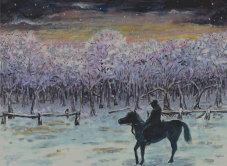

In [320]:
analysis = comprehensive_metadata_analysis(generated_metadata)
print_metadata_summary(analysis)

# To display an image:
display_image(generated_metadata, 0)  # Display the first image

### Pipeline section 3: Connect to MilvusDB and the embedding model to start querying

In [333]:
import os
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings, NVIDIARerank, ChatNVIDIA
from langchain_milvus import Milvus

# TODO: Add your NVIDIA API key here
os.environ["NVIDIA_API_KEY"] = BUILD_API_KEY

embedding = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")

reranker = NVIDIARerank(model="nvidia/nv-rerankqa-mistral-4b-v3")

llm = ChatNVIDIA(model="nvidia/llama-3.1-nemotron-70b-instruct")

vectorstore = Milvus(
    embedding_function=embedding,
    collection_name="nv_ingest_collection",
    primary_field = "pk",
    vector_field = "vector",
    text_field="text",
    connection_args={"uri": "http://host.docker.internal:19530"},
)
retriever = vectorstore.as_retriever()

In [336]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Keep the answer concise."
    "\n\n"
    "{context}"
    "Question: {question}"
)

prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
resp=rag_chain.invoke("What are Robert Frosts poetry collections. Provide the name and year.?")

print(resp)

"Based on the provided context, here are Robert Frost's poetry collections with their respective years:\n\n1. **A Boy's Will** (1913)\n2. **North of Boston** (1914)\n3. **Mountain Interval** (1916)\n4. **New Hampshire** (1923)\n5. **West Running Brook** (1928)\n6. **A Further Range** (1937)\n7. **A Witness Tree** (1942)\n8. **Steeple Bush** (1947)\n9. **In the Clearing** (1962)\n10. **An Afterword** (unknown/year not specified)"